In [4]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt

2025-06-26 12:16:13.977011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750940174.175295      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750940174.232563      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [1]:
!pip install split-folders

In [2]:
import splitfolders
splitfolders.ratio("/kaggle/input/faces-data/data", output="main",seed=1337, ratio=(.7, .2, .1))

Copying files: 5194 files [00:26, 194.86 files/s]


In [5]:
train = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/train",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
val = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/val",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
test = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/test",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)

Found 3635 files belonging to 5 classes.


I0000 00:00:1750940199.963455      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1038 files belonging to 5 classes.
Found 521 files belonging to 5 classes.


## Resnet Scratch

In [6]:

checkpoint  = tensorflow.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/resnet_scrath.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    verbose = 1,
)

early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

requirements = [checkpoint, early_stop]


In [9]:
resnet_scratch = keras.applications.ResNet50(include_top=False,weights=None,input_shape=(224,224,3))

model1 = keras.Sequential([
    resnet_scratch,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1012,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(512,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(17,activation="softmax")
])
model1.summary()

model1.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history_model = model1.fit(train,epochs=50,batch_size=512,validation_data=[val], callbacks = requirements)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1012)                │       2,073,588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1012)                │           4,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1012)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         518,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 17)                  │           8,721 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,194,773 (99.93 MB)

 Trainable params: 26,138,605 (99.71 MB)

 Non-trainable params: 56,168 (219.41 KB)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7498 - loss: 1.0101
Epoch 1: val_loss did not improve from 0.06526
114/114 ━━━━━━━━━━━━━━━━━━━━ 111s 380ms/step - accuracy: 0.7510 - loss: 1.0052 - val_accuracy: 0.3584 - val_loss: 3.7672
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9567 - loss: 0.1446
Epoch 2: val_loss did not improve from 0.06526
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - accuracy: 0.9568 - loss: 0.1442 - val_accuracy: 0.7177 - val_loss: 1.5207
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9948 - loss: 0.0136
Epoch 3: val_loss did not improve from 0.06526
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9948 - loss: 0.0137 - val_accuracy: 0.6474 - val_loss: 2.8761
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9607 - loss: 0.1696
Epoch 4: val_loss did not improve from 0.06526
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9608 - loss: 0.1689 - val_accuracy: 0.824

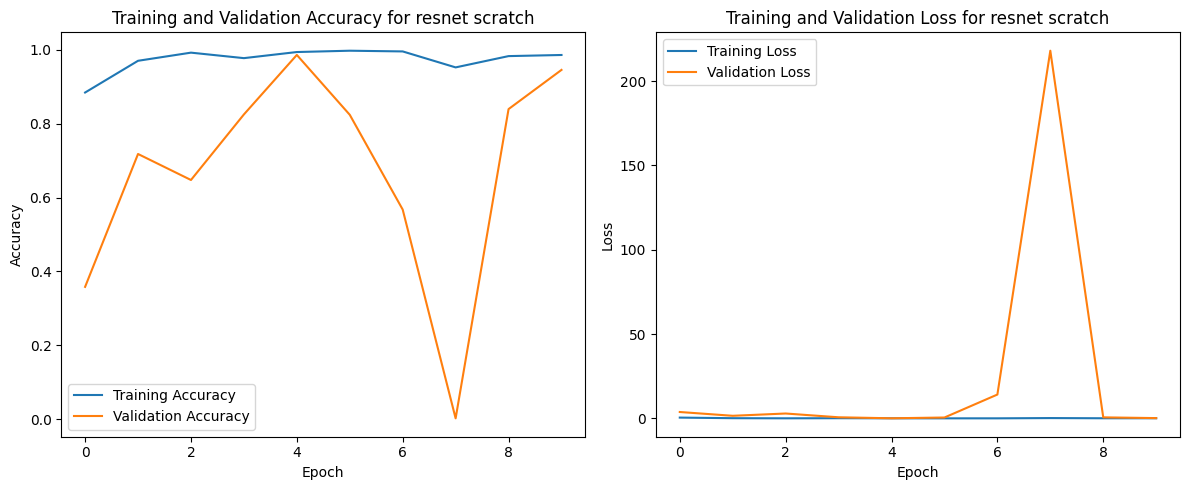

In [10]:
# Plotting the graphs side by side
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for resnet scratch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_model.history['loss'], label='Training Loss')
plt.plot(history_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for resnet scratch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r"/kaggle/working/resnet_scrath.jpg")
plt.show()

## Resnet trans1

In [11]:

checkpoint  = tensorflow.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/resnet_trans1.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    verbose = 1,
)

early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

requirements1 = [checkpoint, early_stop]


In [12]:

resnet_trans1 = keras.applications.ResNet50(include_top=False,weights="imagenet")
for layer in resnet_trans1.layers:
    layer.trainable = False

model2 = keras.Sequential([
    resnet_trans1,
    keras.layers.GlobalAveragePooling2D(), # GlobalAveragePoolingLayer
    keras.layers.Dense(1024,activation="relu"),
    keras.layers.Dense(1024,activation="relu"),
    keras.layers.Dense(17,activation="softmax")
])
model2.summary()
model2.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history_model1 = model2.fit(train,epochs=50,batch_size=512,validation_data=[val], callbacks = requirements1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, None, None, 2048)    │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 17)                  │          17,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,752,913 (102.05 MB)

 Trainable params: 3,165,201 (12.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7547 - loss: 0.8202
Epoch 1: val_loss improved from inf to 0.00374, saving model to /kaggle/working/resnet_trans1.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.7561 - loss: 0.8153 - val_accuracy: 0.9990 - val_loss: 0.0037
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 2: val_loss improved from 0.00374 to 0.00253, saving model to /kaggle/working/resnet_trans1.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9990 - val_loss: 0.0025
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 2.9330e-04
Epoch 3: val_loss improved from 0.00253 to 0.00013, saving model to /kaggle/working/resnet_trans1.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 1.0000 - loss: 2.9269e-04 - val_accuracy: 1.0000 - val_loss: 1.2961e-04
Epoch 4/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy

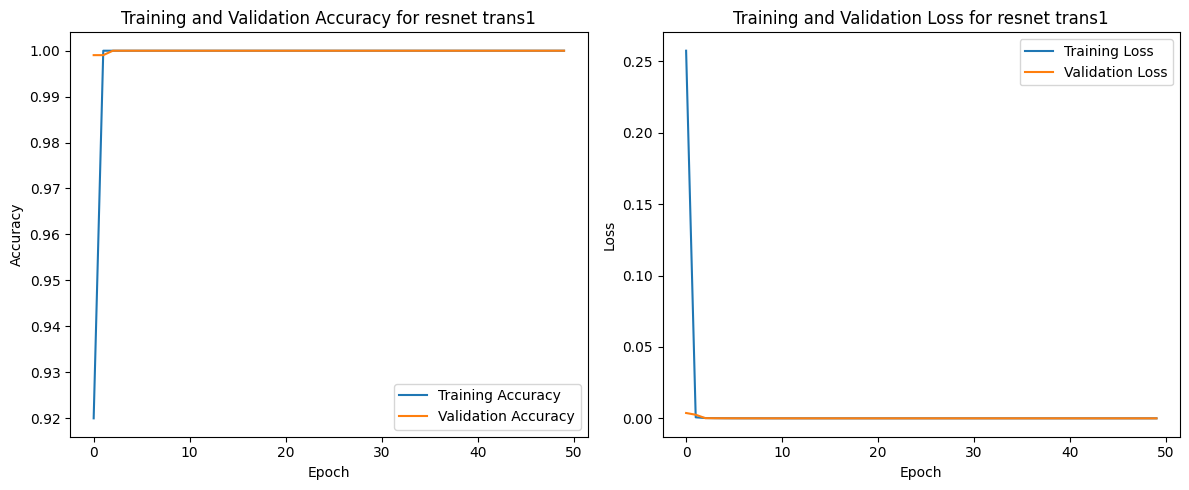

In [13]:
# Plotting the graphs side by side
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_model1.history['accuracy'], label='Training Accuracy')
plt.plot(history_model1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for resnet trans1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_model1.history['loss'], label='Training Loss')
plt.plot(history_model1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for resnet trans1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r"/kaggle/working/resnet_trans1.jpg")
plt.show()

## Resnet trans2

In [14]:

checkpoint  = tensorflow.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/resnet_trans2.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    verbose = 1,
)

early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

requirements2 = [checkpoint, early_stop]


In [18]:
resnet_trans2 = keras.applications.ResNet50(include_top=False,weights="imagenet")

for layer in resnet_trans2.layers:
    if layer.name == 'conv2_block1_2_conv' or  layer.name == 'conv5_block1_1_relu' or layer.name ==  'conv5_block3_3_conv' or layer.name == "block5_conv2" or layer.name == "conv4_block5_1_relu":
      layer.trainable = False

model3 = keras.Sequential([
    resnet_trans2,
    keras.layers.GlobalAveragePooling2D(), # GlobalAveragePoolingLayer
    keras.layers.Dense(1000,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(1000,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(17,activation="softmax")
])
model3.summary()
model3.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history_model2 = model3.fit(train,epochs=50,batch_size=512,validation_data=val,callbacks=requirements2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, None, None, 2048)    │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 17)                  │          17,017 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,658,729 (101.69 MB)

 Trainable params: 25,516,057 (97.34 MB)

 Non-trainable params: 1,142,672 (4.36 MB)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8685 - loss: 2.7195
Epoch 1: val_loss did not improve from 0.05554
114/114 ━━━━━━━━━━━━━━━━━━━━ 108s 361ms/step - accuracy: 0.8690 - loss: 2.7160 - val_accuracy: 0.2457 - val_loss: 58.6849
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9792 - loss: 1.6017
Epoch 2: val_loss did not improve from 0.05554
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9792 - loss: 1.6002 - val_accuracy: 0.5829 - val_loss: 11.9362
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9849 - loss: 0.9569
Epoch 3: val_loss did not improve from 0.05554
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9849 - loss: 0.9558 - val_accuracy: 0.9875 - val_loss: 0.6214
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9906 - loss: 0.5461
Epoch 4: val_loss did not improve from 0.05554
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9906 - loss: 0.5456 - val_accuracy: 0.9

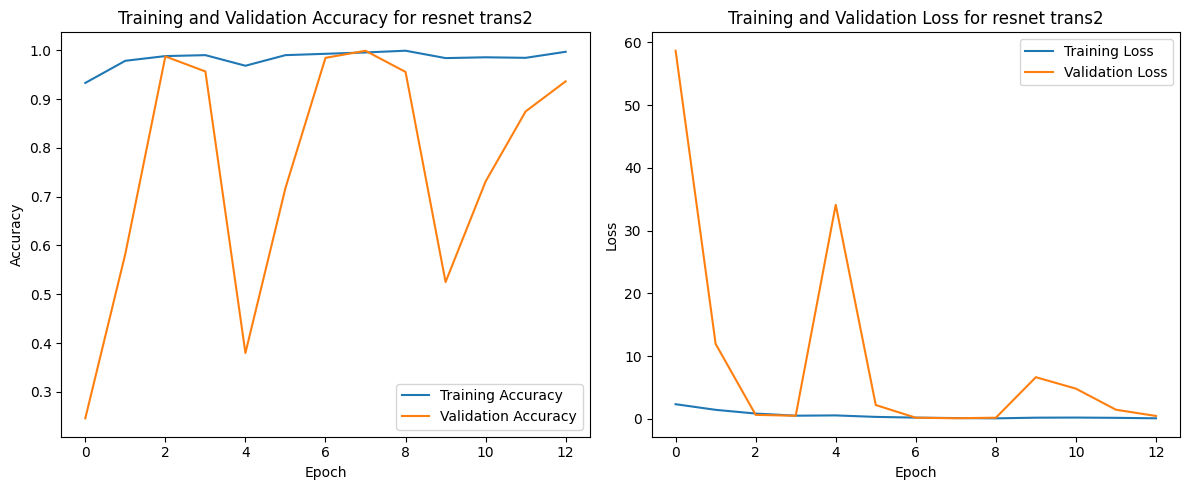

In [19]:
# Plotting the graphs side by side
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_model2.history['accuracy'], label='Training Accuracy')
plt.plot(history_model2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for resnet trans2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_model2.history['loss'], label='Training Loss')
plt.plot(history_model2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for resnet trans2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r"/kaggle/working/resnet_trans2.jpg")
plt.show()